In [9]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Custom Dataset class for Underwater Creatures
class UnderwaterCreaturesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split  # 'train', 'valid', or 'test'
        self.transform = transform

        # Directories for images and labels
        self.images_dir = os.path.join(root_dir, split, 'images')
        self.labels_dir = os.path.join(root_dir, split, 'labels')

        # Get list of image files
        self.image_files = os.listdir(self.images_dir)

        # Build index mapping from dataset index to (image_path, bbox, label)
        self.samples = []  # list of tuples: (image_path, bbox, label)

        for image_file in self.image_files:
            image_path = os.path.join(self.images_dir, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            class_id, x_center, y_center, width, height = map(float, parts)
                            bbox = [x_center, y_center, width, height]
                            self.samples.append((image_path, bbox, int(class_id)))
            else:
                # Handle images without labels if necessary
                pass

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, bbox, class_id = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        width, height = image.size

        # Convert bbox from normalized coordinates to pixel coordinates
        x_center, y_center, bbox_width, bbox_height = bbox
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height

        xmin = int(x_center - bbox_width / 2)
        ymin = int(y_center - bbox_height / 2)
        xmax = int(x_center + bbox_width / 2)
        ymax = int(y_center + bbox_height / 2)

        # Crop the image to the bounding box
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, class_id

# Define data transformations for training and validation/testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


In [3]:
# Root directory of the dataset
root_dir = 'aquarium-data-cots/aquarium_pretrain'

# Create datasets
train_dataset = UnderwaterCreaturesDataset(root_dir, split='train', transform=train_transform)
valid_dataset = UnderwaterCreaturesDataset(root_dir, split='valid', transform=test_transform)
test_dataset = UnderwaterCreaturesDataset(root_dir, split='test', transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Use a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/ubuntu/micromamba/envs/deepl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/micromamba/envs/deepl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.9MB/s]


In [5]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')


Epoch 1/10, Loss: 0.7063, Accuracy: 78.55%
Validation Loss: 0.4133, Validation Accuracy: 87.68%
Epoch 2/10, Loss: 0.1947, Accuracy: 94.04%
Validation Loss: 0.3337, Validation Accuracy: 90.32%
Epoch 3/10, Loss: 0.1049, Accuracy: 97.26%
Validation Loss: 0.2865, Validation Accuracy: 90.87%
Epoch 4/10, Loss: 0.0761, Accuracy: 97.83%
Validation Loss: 0.3597, Validation Accuracy: 90.32%
Epoch 5/10, Loss: 0.0561, Accuracy: 98.68%
Validation Loss: 0.3199, Validation Accuracy: 91.09%
Epoch 6/10, Loss: 0.0464, Accuracy: 98.77%
Validation Loss: 0.3273, Validation Accuracy: 91.09%
Epoch 7/10, Loss: 0.0283, Accuracy: 99.37%
Validation Loss: 0.2986, Validation Accuracy: 91.31%
Epoch 8/10, Loss: 0.0248, Accuracy: 99.34%
Validation Loss: 0.2922, Validation Accuracy: 91.64%
Epoch 9/10, Loss: 0.0289, Accuracy: 99.16%
Validation Loss: 0.3237, Validation Accuracy: 90.65%
Epoch 10/10, Loss: 0.0255, Accuracy: 99.16%
Validation Loss: 0.3765, Validation Accuracy: 90.21%


In [6]:
# Testing
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 90.24%


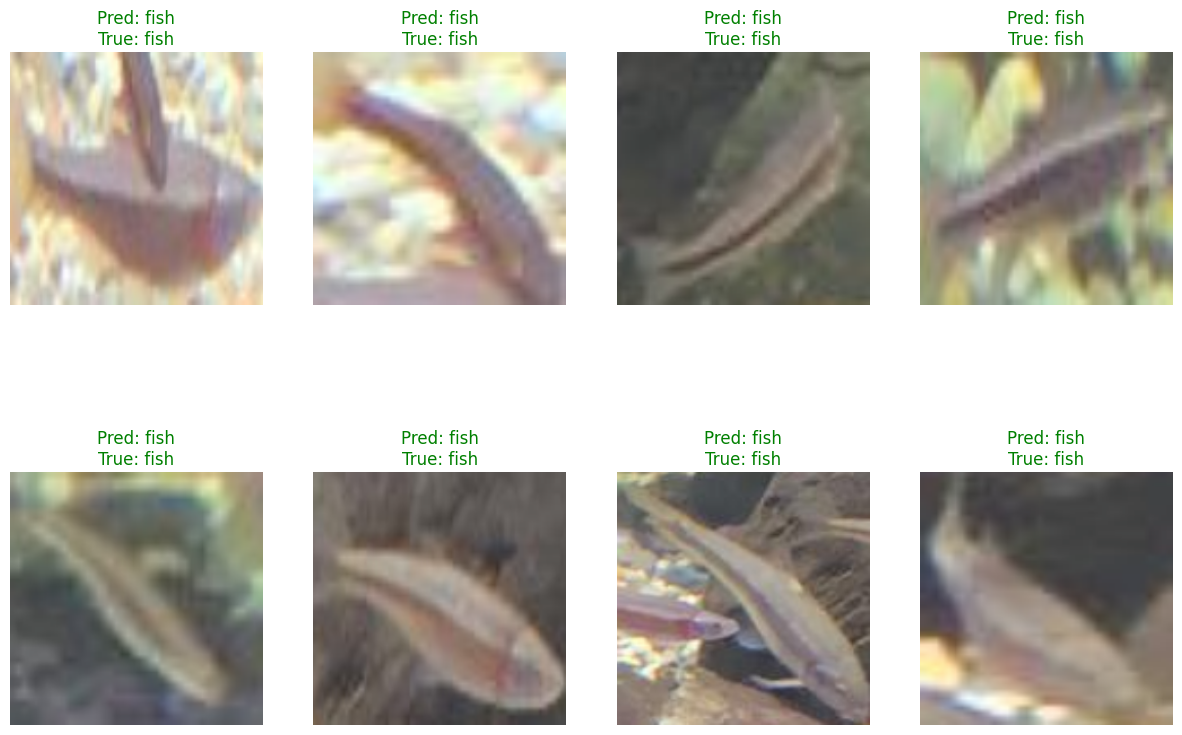

In [15]:
# Get class names
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std =[0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

import numpy as np

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move the inputs and labels to the device
images = images.to(device)
labels = labels.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Move images to CPU for visualization
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Plot the images with predicted and true labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(8):  # Display first 8 images
    ax = fig.add_subplot(2, 4, idx+1)
    imshow(images[idx])
    ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}",
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()


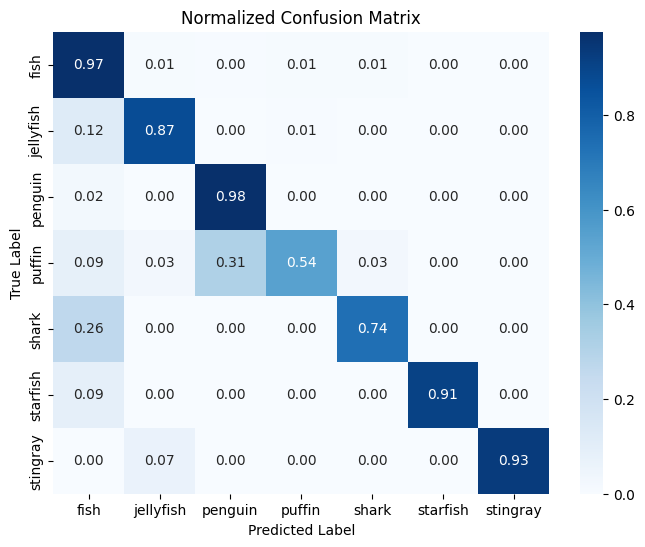

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.show()
